In [51]:
import numpy as np
import matplotlib.pyplot as plt

In all cases below, p is an observed distribution (so, our observed fatalities) and q is a distribution aiming to approximate p (so, our predictions).  
In all cases the below "+ esp" is simply there for numerical stability. It adds a very small numper ($e^{-100}$) to both q and p so that we neither divide with zero or take the log of zero anywhere

In [52]:
def tweedie_loss(p, q, pow=1.5, eps=np.exp(-100)):

    """
    The Tweedie loss function is defined as: $L(p, q) = -p q^{1-pow} / (1-pow) + q^{2-pow} / (2-pow)$. 
    I is used to evaluate the performance of a model that predicts the mean of a Tweedie distribution. 
    The parameter $pow$ controls the variance of the distribution. For $pow < 1$, the variance is infinite. 
    For $pow = 1$, the variance is 0. For $pow > 1$, the variance is finite. 
    The parameter $eps$ is used to avoid numerical issues when $pow < 1$.
    """

    p = p + eps
    q = q + eps 

    loss = -p * np.power(q, 1 - pow) / (1 - pow) + np.power(q, 2 - pow) / (2 - pow)
    return np.mean(loss)

In [53]:
def kl_divergence(p, q, eps=np.exp(-100)):

    """
    The KL divergence between two discrete distributions p and q is defined as: $\sum_i p_i \log(p_i / q_i)$. 
    It describes the difference between two distributions in terms of information lost when q is used to approximate p.
    The parameter $eps$ is used to avoid numerical issues when $pow < 1$.
    """

    p = p + eps
    q = q + eps

    return np.sum(p * np.log(p / q))

In [54]:
def jeffreys_divergence(p, q, eps=np.exp(-100)):

    """
    Jeffreys divergence is a symmetrized version of KL divergence. See https://en.wikipedia.org/wiki/Hellinger_distance
    The parameter $eps$ is used to avoid numerical issues when $pow < 1$.
    """

    p = p + eps
    q = q + eps

    return 0.5 * np.sum((p - q) * np.log(p / q)) 

In [55]:
def jenson_shannon_divergence(p, q, eps=np.exp(-100)):

    """
    Jenson-Shannon divergence is also a symmetrized version of KL divergence. See https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    JSD = 0.5 * KL(p, m) + 0.5 * KL(q, m)
    The parameter $eps$ is used to avoid numerical issues when $pow < 1$.
    """

    p = p + eps
    q = q + eps

    m = 0.5 * (p + q)

    return 0.5 * np.sum(p * np.log(p / m) + q * np.log(q / m))

In [56]:
def zero_inflated_distribution(num_data_points = 100000):

    """
    Generate a zero inflated distribution with 5% non-zero values and 0.1% +1000 values
    """

    data = np.zeros(num_data_points)

    # get index for 5% non-zero values
    num_non_zero = int(num_data_points * 0.05)
    non_zero_indices = np.random.choice(num_data_points, num_non_zero, replace=False)

    # get index for 0.1% +1000 values
    num_1000 = int(num_data_points * 0.001)
    indices_1000 = np.random.choice(num_data_points, num_1000, replace=False)

    # add the non-zero and +1000 values
    data[non_zero_indices] =  np.abs(np.random.normal(1,10, num_non_zero))   
    data[indices_1000]= np.abs(np.random.normal(1000,1000, num_1000))   

    return data
    

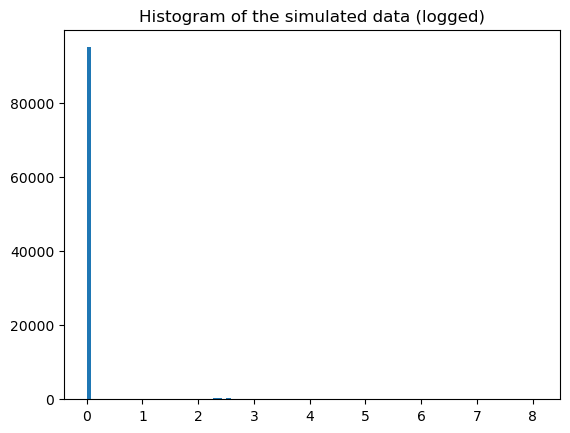

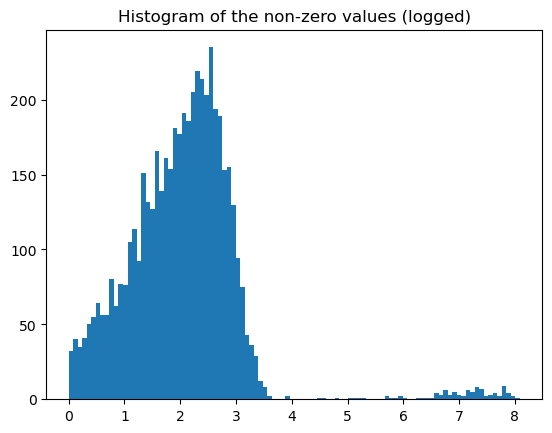

In [57]:
data = zero_inflated_distribution()

# plot the histogram
plt.title("Histogram of the simulated data (logged)")
plt.hist(np.log(data+1), bins=100)   
plt.show()

# plot the histogram of non-zero values
plt.title("Histogram of the non-zero values (logged)")
plt.hist(np.log(data[data>0]+1), bins=100)
plt.show()

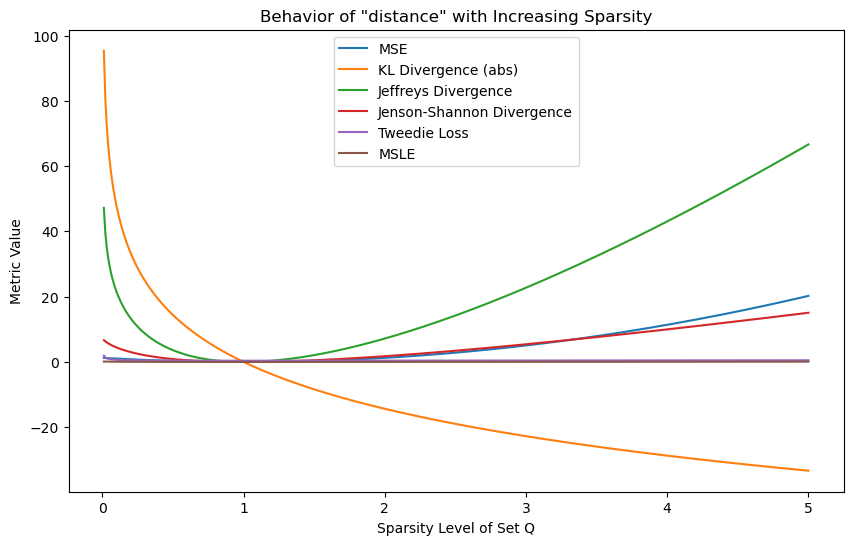

/tmp/ipykernel_4815/3575026579.py:70: RuntimeWarning: invalid value encountered in log
  plt.plot(sparsity_levels, np.log(np.array(kl_values)+1), label='KL Divergence, logged')


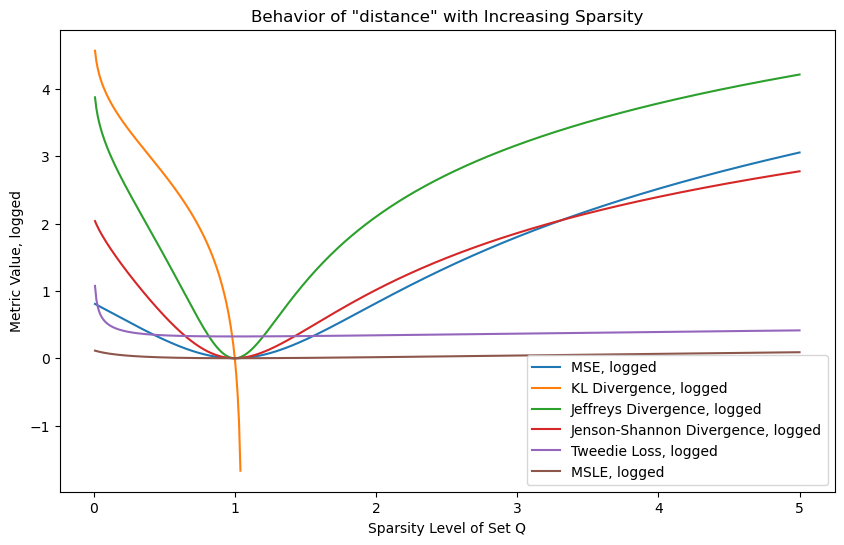

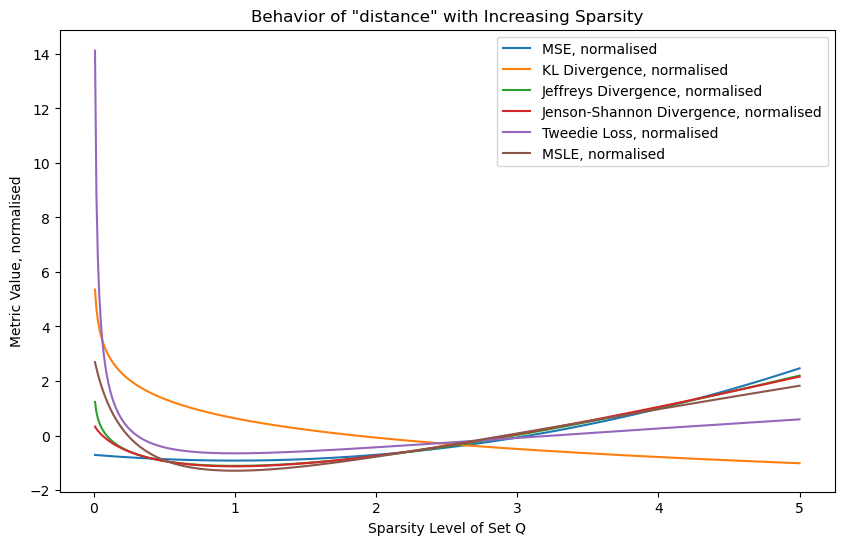

In [65]:
# Parameters
num_data_points = 100
dense_percentage = 0.95
sparse_percentage_step = 0.01

# Initialize lists to store results
sparsity_levels = []
mse_values = []
msle_values = []
kl_values = []
j_values = []
js_values = []
t_values = []

data_p = zero_inflated_distribution(num_data_points=num_data_points)

# Simulation loop
for sparsity in np.arange(0.01, 5+sparse_percentage_step, sparse_percentage_step):
    # Generate sparse set Q
    data_q = data_p * sparsity #+ np.random.normal(0, 1, num_data_points)**2

    # Calculate MSE
    mse = np.mean((data_p - data_q)**2)
    mse_values.append(mse)

    # Calculate MSLE
    msle = np.mean((np.log(data_p+1) - np.log(data_q+1))**2)
    msle_values.append(msle)

    # Calculate KL Divergence
    kl_div = kl_divergence(data_p, data_q)
    kl_values.append(kl_div)

    # Calculate J Divergence
    j_div = jeffreys_divergence(data_p, data_q)
    j_values.append(j_div)

    # Calculate JS Divergence
    js_div = jenson_shannon_divergence(data_p, data_q)
    js_values.append(js_div)

    # Calculate Tweedie Loss
    t_loss = tweedie_loss(data_p, data_q, pow = 1.5)
    t_values.append(t_loss)

    # Save sparsity level for plotting
    sparsity_levels.append(sparsity)

# Plotting
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, np.array(mse_values), label='MSE')
plt.plot(sparsity_levels, np.array(kl_values), label='KL Divergence (abs)')
plt.plot(sparsity_levels, np.array(j_values), label='Jeffreys Divergence')
plt.plot(sparsity_levels, np.array(js_values), label='Jenson-Shannon Divergence')
plt.plot(sparsity_levels, np.array(t_values), label='Tweedie Loss')
plt.plot(sparsity_levels, np.array(msle_values), label='MSLE')

plt.xlabel('Sparsity Level of Set Q')
plt.ylabel('Metric Value')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, np.log(np.array(mse_values)+1), label='MSE, logged')
plt.plot(sparsity_levels, np.log(np.array(kl_values)+1), label='KL Divergence, logged')
plt.plot(sparsity_levels, np.log(np.array(j_values)+1), label='Jeffreys Divergence, logged')
plt.plot(sparsity_levels, np.log(np.array(js_values)+1), label='Jenson-Shannon Divergence, logged')
plt.plot(sparsity_levels, np.log(np.array(t_values)+1), label='Tweedie Loss, logged')
plt.plot(sparsity_levels, np.log(np.array(msle_values)+1), label='MSLE, logged')

plt.xlabel('Sparsity Level of Set Q')
plt.ylabel('Metric Value, logged')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, (np.array(mse_values)-np.array(mse_values).mean())/np.array(mse_values).std(), label='MSE, normalised')
plt.plot(sparsity_levels, (np.array(kl_values)-np.array(kl_values).mean())/np.array(kl_values).std(), label='KL Divergence, normalised')
plt.plot(sparsity_levels, (np.array(j_values)-np.array(j_values).mean())/np.array(j_values).std(), label='Jeffreys Divergence, normalised')
plt.plot(sparsity_levels, (np.array(js_values)-np.array(js_values).mean())/np.array(js_values).std(), label='Jenson-Shannon Divergence, normalised')
plt.plot(sparsity_levels, (np.array(t_values)-np.array(t_values).mean())/np.array(t_values).std(), label='Tweedie Loss, normalised')
plt.plot(sparsity_levels, (np.array(msle_values)-np.array(msle_values).mean())/np.array(msle_values).std(), label='MSLE, normalised')

plt.xlabel('Sparsity Level of Set Q')
plt.ylabel('Metric Value, normalised')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()

plt.show()

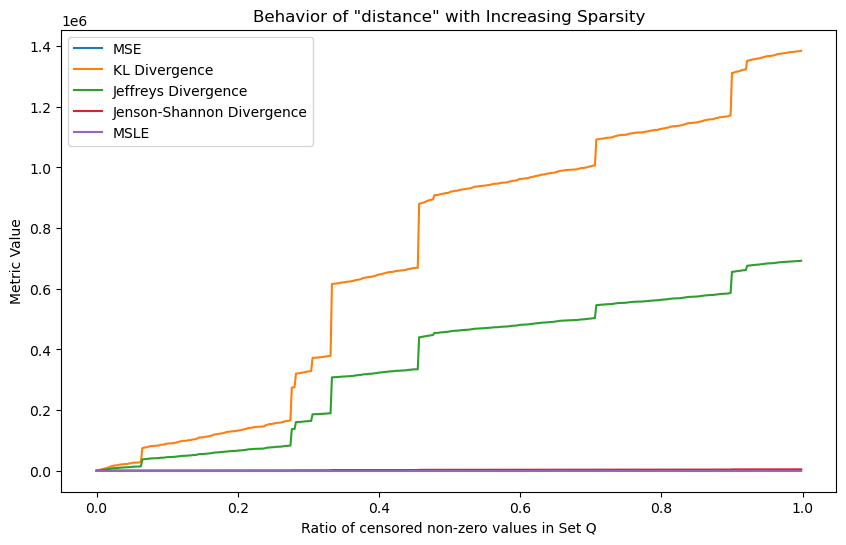

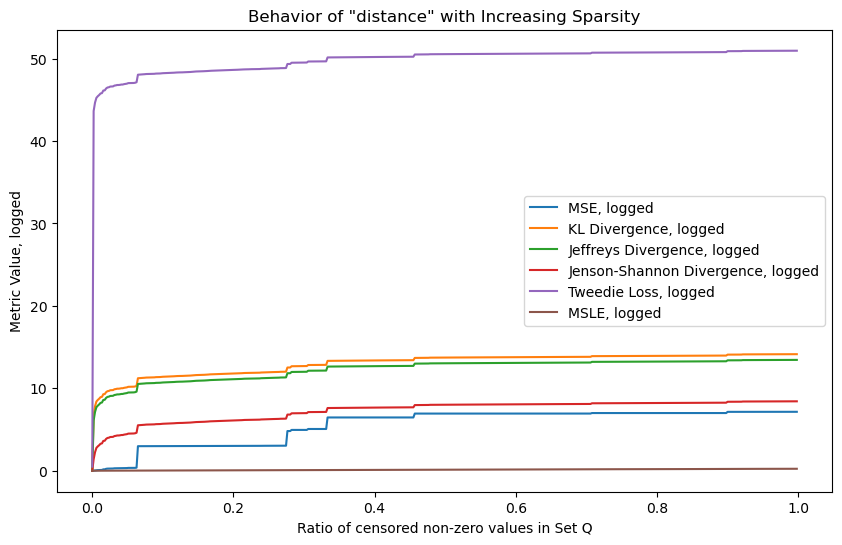

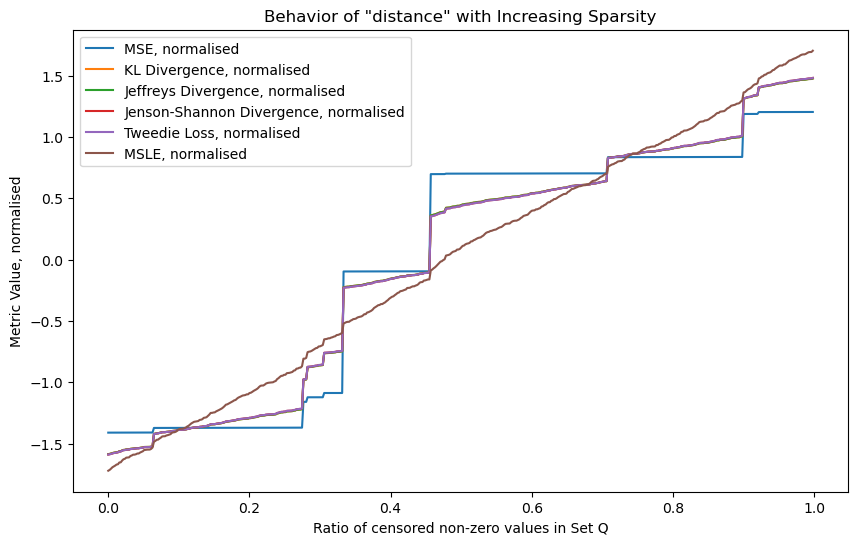

In [59]:
# Initialize lists to store results
num_data_points = 10000
zero_ratio = []
mse_values = []
msle_values = []
kl_values = []
j_values = []
js_values = []
t_values = []

data_p = zero_inflated_distribution(num_data_points=num_data_points)
data_q = data_p.copy()


# Parameters
non_zero_indices = np.where(data_q>0)[0]


# Simulation loop
for i in np.arange(non_zero_indices.shape[0]):

    #change one non-zero value to zero in q
    if i > 0:
        data_q[non_zero_indices[i-1]] = 0
    
    # Calculate MSE
    mse = np.mean((data_p - data_q)**2)
    mse_values.append(mse)

    # Calculate MSLE
    msle = np.mean((np.log(data_p+1) - np.log(data_q+1))**2)
    msle_values.append(msle)

    # Calculate KL Divergence
    kl_div = kl_divergence(data_p, data_q)
    kl_values.append(kl_div)

    # Calculate J Divergence
    j_div = jeffreys_divergence(data_p, data_q)
    j_values.append(j_div)

    # Calculate JS Divergence
    js_div = jenson_shannon_divergence(data_p, data_q)
    js_values.append(js_div)


    # Calculate Tweedie Loss
    t_loss = tweedie_loss(data_p, data_q, pow = 1.5)
    t_values.append(t_loss)

    # Save ratio of non-zero values for plotting
    zero_ratio.append(i/non_zero_indices.shape[0])

# Plotting

plt.figure(figsize=(10, 6))
plt.plot(zero_ratio, np.array(mse_values), label='MSE')
plt.plot(zero_ratio, np.array(kl_values), label='KL Divergence')
plt.plot(zero_ratio, np.array(j_values), label='Jeffreys Divergence')
plt.plot(zero_ratio, np.array(js_values), label='Jenson-Shannon Divergence')
#plt.plot(zero_ratio, np.array(t_values), label='Tweedie Loss')
plt.plot(zero_ratio, np.array(msle_values), label='MSLE')

plt.xlabel('Ratio of censored non-zero values in Set Q')
plt.ylabel('Metric Value')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(zero_ratio, np.log(np.array(mse_values)+1), label='MSE, logged')
plt.plot(zero_ratio, np.log(np.array(kl_values)+1), label='KL Divergence, logged')
plt.plot(zero_ratio, np.log(np.array(j_values)+1), label='Jeffreys Divergence, logged')
plt.plot(zero_ratio, np.log(np.array(js_values)+1), label='Jenson-Shannon Divergence, logged')
plt.plot(zero_ratio, np.log(np.array(t_values)+1), label='Tweedie Loss, logged')
plt.plot(zero_ratio, np.log(np.array(msle_values)+1), label='MSLE, logged')

plt.xlabel('Ratio of censored non-zero values in Set Q')
plt.ylabel('Metric Value, logged')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(zero_ratio, (np.array(mse_values)-np.array(mse_values).mean())/np.array(mse_values).std(), label='MSE, normalised')
plt.plot(zero_ratio, (np.array(kl_values)-np.array(kl_values).mean())/np.array(kl_values).std(), label='KL Divergence, normalised')
plt.plot(zero_ratio, (np.array(j_values)-np.array(j_values).mean())/np.array(j_values).std(), label='Jeffreys Divergence, normalised')
plt.plot(zero_ratio, (np.array(js_values)-np.array(js_values).mean())/np.array(js_values).std(), label='Jenson-Shannon Divergence, normalised')
plt.plot(zero_ratio, (np.array(t_values)-np.array(t_values).mean())/np.array(t_values).std(), label='Tweedie Loss, normalised')
plt.plot(zero_ratio, (np.array(msle_values)-np.array(msle_values).mean())/np.array(msle_values).std(), label='MSLE, normalised')

plt.xlabel('Ratio of censored non-zero values in Set Q')
plt.ylabel('Metric Value, normalised')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()

plt.show()

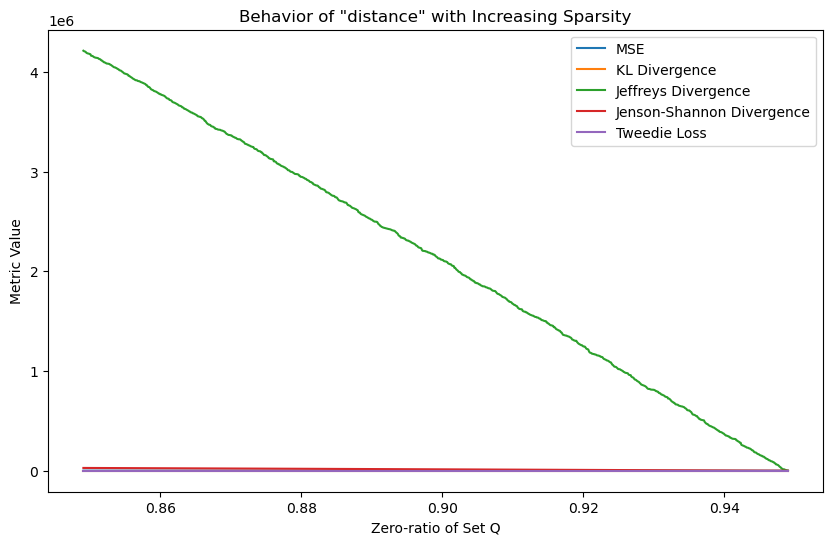

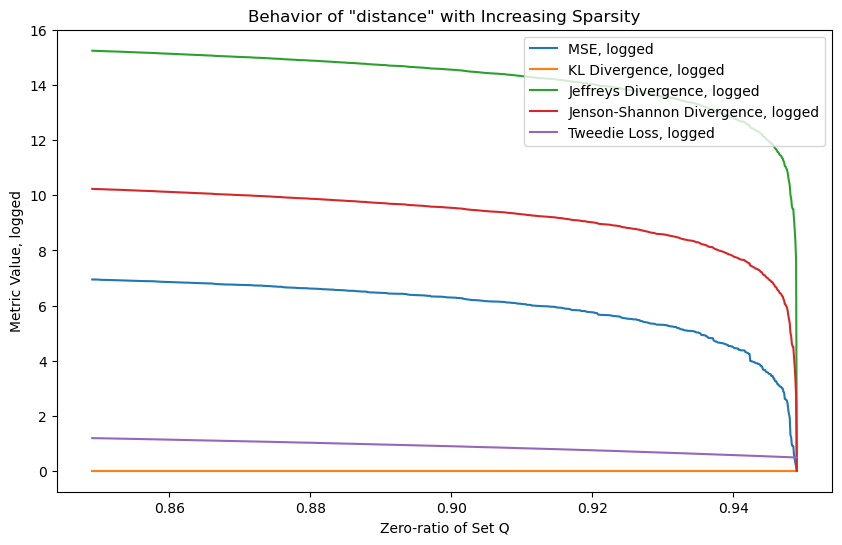

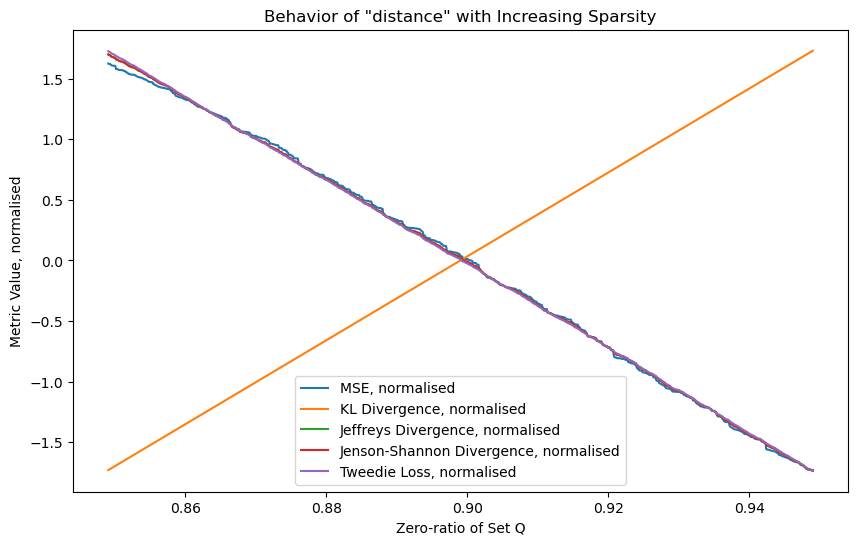

In [60]:
# Initialize lists to store results
num_data_points = 10000
zero_ratio = []
mse_values = []
kl_values = []
j_values = []
js_values = []
t_values = []

data_p = zero_inflated_distribution(num_data_points=num_data_points)
data_q = data_p.copy()


# Parameters
zero_indices = np.where(data_q==0)[0]


# Simulation loop
for i in np.arange(1000):

    #change one non-zero value to zero in q
    if i > 0:
        data_q[zero_indices[i-1]] = np.abs(np.random.normal(1,100, 1))
    
    # Calculate MSE
    mse = np.mean((data_p - data_q)**2)
    mse_values.append(mse)

    # Calculate KL Divergence
    kl_div = kl_divergence(data_p, data_q)
    kl_values.append(kl_div)

    # Calculate J Divergence
    j_div = jeffreys_divergence(data_p, data_q)
    j_values.append(j_div)

    # Calculate JS Divergence
    js_div = jenson_shannon_divergence(data_p, data_q)
    js_values.append(js_div)


    # Calculate Tweedie Loss
    t_loss = tweedie_loss(data_p, data_q, pow = 1.5)
    t_values.append(t_loss)

    # Save sparsity level for plotting
    zero_ratio.append(data_q[data_q==0].shape[0]/num_data_points)

# Plotting

plt.figure(figsize=(10, 6))
plt.plot(zero_ratio, np.array(mse_values), label='MSE')
plt.plot(zero_ratio, np.array(kl_values), label='KL Divergence')
plt.plot(zero_ratio, np.array(j_values), label='Jeffreys Divergence')
plt.plot(zero_ratio, np.array(js_values), label='Jenson-Shannon Divergence')
plt.plot(zero_ratio, np.array(t_values), label='Tweedie Loss')


plt.xlabel('Zero-ratio of Set Q')
plt.ylabel('Metric Value')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(zero_ratio, np.log(np.array(mse_values)+1), label='MSE, logged')
plt.plot(zero_ratio, np.log(np.array(kl_values)+1), label='KL Divergence, logged')
plt.plot(zero_ratio, np.log(np.array(j_values)+1), label='Jeffreys Divergence, logged')
plt.plot(zero_ratio, np.log(np.array(js_values)+1), label='Jenson-Shannon Divergence, logged')
plt.plot(zero_ratio, np.log(np.array(t_values)+1), label='Tweedie Loss, logged')


plt.xlabel('Zero-ratio of Set Q')
plt.ylabel('Metric Value, logged')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(zero_ratio, (np.array(mse_values)-np.array(mse_values).mean())/np.array(mse_values).std(), label='MSE, normalised')
plt.plot(zero_ratio, (np.array(kl_values)-np.array(kl_values).mean())/np.array(kl_values).std(), label='KL Divergence, normalised')
plt.plot(zero_ratio, (np.array(j_values)-np.array(j_values).mean())/np.array(j_values).std(), label='Jeffreys Divergence, normalised')
plt.plot(zero_ratio, (np.array(js_values)-np.array(js_values).mean())/np.array(js_values).std(), label='Jenson-Shannon Divergence, normalised')
plt.plot(zero_ratio, (np.array(t_values)-np.array(t_values).mean())/np.array(t_values).std(), label='Tweedie Loss, normalised')

plt.xlabel('Zero-ratio of Set Q')
plt.ylabel('Metric Value, normalised')
plt.title('Behavior of "distance" with Increasing Sparsity')
plt.legend()

plt.show()